In [1]:
# Import libraries
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Increase the maximum number of pixels PIL will process in an image
PIL.Image.MAX_IMAGE_PIXELS = None #Increase image size limit

---
### `detect_leaves` function
The `detect_leaves` function in the code identifies areas in an image that are likely to be leaves based on their size and shape. It applies image processing techniques like blurring, binarization, and contour detection, and returns the locations of these areas as bounding boxes.

In [2]:
# Constants
BLUR_KERNEL_SIZE = (80, 80)
THRESHOLD_AREA = 600000
BINARY_THRESHOLD = 128
MAX_BINARY_VALUE = 255
BINARY_INV_THRESHOLD = 245
MIN_WIDTH = 400
MIN_HEIGHT = 5000

def blur_image(input_image, kernel_size):
    """
    Apply a blur to the input image.

    Blurring is used as a preprocessing step in our image processing pipeline. 
    It helps to reduce noise and detail in the image. By doing so, it simplifies 
    the image and makes subsequent processing steps like binarization and contour 
    detection more effective. The level of blurring is controlled by the kernel size: 
    a larger kernel will produce a more blurred image.

    Args:
    input_image (numpy.ndarray): The input image to be blurred.
    kernel_size (tuple): The size of the kernel to be used for blurring. 
                         The kernel is a rectangle of size kernel_size that 
                         moves over the image to average the pixel values.

    Returns:
    numpy.ndarray: The blurred version of the input image.
    """
    return cv2.blur(input_image, kernel_size)



def binarize_and_invert_image(image, bin_threshold, max_value, inv_threshold):
    """
    Binarize and invert the image using specific thresholds.

    This function is a key part of the image processing pipeline for leaf detection. 
    It first binarizes the image, converting it to a binary image where pixels are 
    either black or white based on the provided threshold. This simplifies the image 
    and makes it easier to detect the leaves.

    After binarization, the function converts the image to grayscale. This is done 
    because the inversion function works on single channel images, and the binarization 
    process may leave the image in a multi-channel state.

    Finally, the function inverts the binary image. In the context of leaf detection, 
    this step helps to highlight the leaves (which are now white) against the background 
    (which is now black).

    Args:
    image (numpy.ndarray): The input image to be processed.
    bin_threshold (int): The threshold for binarization. Pixels with a value greater 
                         than this threshold will be set to the max_value.
    max_value (int): The value to be given to pixels that exceed the bin_threshold.
    inv_threshold (int): The threshold for inversion. Pixels with a value greater than 
                         this threshold will be set to 0 (black), and those with a 
                         value less than or equal to this threshold will be set to 
                         max_value (white).

    Returns:
    numpy.ndarray: The processed image, which is a grayscale, binary, inverted version 
                   of the input image.
    """
    _, binarized_image = cv2.threshold(image, bin_threshold, max_value, cv2.THRESH_BINARY)
    grayscale_image = cv2.cvtColor(binarized_image, cv2.COLOR_BGR2GRAY)
    _, inverted_image = cv2.threshold(grayscale_image, inv_threshold, max_value, cv2.THRESH_BINARY_INV)
    
    return inverted_image



def find_and_filter_contours(image, threshold_area, min_width, min_height):
    """
    Find contours in the image and filter them based on area, width, and height.

    Args:
    image (numpy.ndarray): The input image, which should be a binary image where the 
                           leaves are white and the background is black.
    threshold_area (int): The minimum area for a contour to be considered. Contours 
                          with an area less than this will be ignored.
    min_width (int): The minimum width for a contour to be considered. Contours with 
                     a width less than this will be ignored.
    min_height (int): The minimum height for a contour to be considered. Contours with 
                      a height less than this will be ignored.

    Returns:
    numpy.ndarray: An array of bounding boxes for the filtered contours, sorted from 
                   left to right. Each bounding box is represented as a list of four 
                   coordinates [x, y, x+w, y+h].
    """
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    bounding_boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > threshold_area:
            x, y, w, h = cv2.boundingRect(c)
            if w > min_width and h > min_height:
                bounding_boxes.append([x, y, x+w, y+h])
    
    # Sort the bounding boxes from left to right
    bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])
    
    return np.array(bounding_boxes)



def detect_leaves(input_image):
    """
    Detects and returns bounding boxes around specific areas (leaves) in the input image.
    
    Args:
    input_image (numpy.ndarray): Input image to detect leaves from.
    
    Returns:
    numpy.ndarray: Array containing bounding boxes around leaves.
    """
    blurred_image = blur_image(input_image, BLUR_KERNEL_SIZE)
    processed_image = binarize_and_invert_image(blurred_image, BINARY_THRESHOLD, MAX_BINARY_VALUE, BINARY_INV_THRESHOLD)
    bounding_boxes = find_and_filter_contours(processed_image, THRESHOLD_AREA, MIN_WIDTH, MIN_HEIGHT)
    return bounding_boxes

---
### Example of leaves detection :

Corrupt JPEG data: 4110 extraneous bytes before marker 0xd5


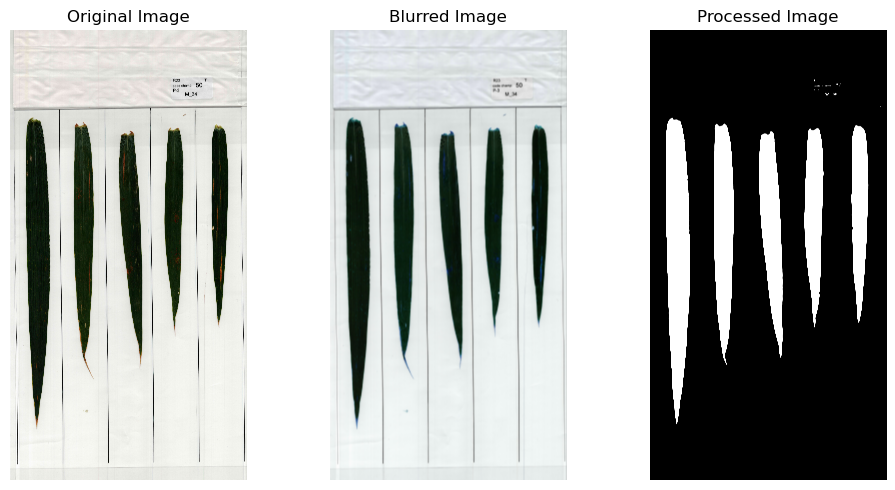

leaves coordinates : 
[[  689  3839  1756 17226]
 [ 2774  4087  3663 14651]
 [ 4749  4420  5784 14320]
 [ 6730  4286  7570 12985]
 [ 8782  4155  9528 12790]]
Time taken to process leaves detection : 1.072 seconds


In [3]:
start_time = time.time()
input_image = cv2.imread('/Users/titouanlegourrierec/Desktop/all_scan_data/all_090523/1.jpg')
blurred_image = blur_image(input_image, BLUR_KERNEL_SIZE)
processed_image = binarize_and_invert_image(blurred_image, BINARY_THRESHOLD, MAX_BINARY_VALUE, BINARY_INV_THRESHOLD)
bounding_boxes = find_and_filter_contours(processed_image, THRESHOLD_AREA, MIN_WIDTH, MIN_HEIGHT)
end_time = time.time()

plt.figure(figsize=(10, 5))  # Optional: Set the figure size

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.tight_layout()  # Optional: Improve the spacing between subplots
plt.show()

print(f"leaves coordinates : \n{bounding_boxes}")
print(f"Time taken to process leaves detection : {end_time - start_time:.3f} seconds")

---
### `is_image_usable` function
The `is_image_usable` function's goal is to determine whether an image is usable or not based on its dimensions. We have experimentally found that issues during leaf scanning are associated with images that are either too small or too large in dimensions.

In [4]:
# Define the threshold values for image dimensions as constants
MIN_HEIGHT_FILE = 11000 # Minimum acceptable image height in pixels
MAX_HEIGHT_FILE = 22500 # Maximum acceptable image height in pixels

def is_image_usable(image):
    """
    Checks if the image is usable based on its dimensions.
    
    Args:
    image (numpy.ndarray): Input image to check for usability.
    
    Returns:
    bool: True if the image is usable, False otherwise.
    """
    # Get the height of the image
    height = image.shape[0]
    
    # Check if the height is within the acceptable range
    return MIN_HEIGHT_FILE <= height <= MAX_HEIGHT_FILE

---

In [5]:
import os
import cv2

# Define constants
IMAGE_EXTENSIONS = ['.jpg', '.png']
NEW_RESULTS_DIR = 'new_results'
FILE_DIR = 'File'
UNUSABLE_FILE_DIR = 'Unusable_File'



def count_files_in_directory(directory, extensions):
    """
    Count the number of files in a directory that have a certain extension.

    Args:
    directory (str): The path to the directory to search.
    extensions (list): A list of file extensions to count.

    Returns:
    int: The number of files in the directory that have one of the specified extensions.
    """
    # os.path.splitext(filename)[1] gets the file extension of filename
    # .lower() converts the extension to lowercase for case-insensitive comparison
    return sum(os.path.splitext(filename)[1].lower() in extensions for filename in os.listdir(directory))



def create_directory(path):
    """
    Creates a new directory.

    This function uses the os.makedirs() function to create a new directory at the specified path.
    The exist_ok parameter is set to True, which means the function will not raise an error if the directory already exists.

    Args:
    path (str): The path where the new directory should be created.
    """
    os.makedirs(path, exist_ok=True)


def image_processing(entry_path, exit_path):
    """
    Process all image files in a directory: count them, create necessary directories, process each image, and print the results.

    Args:
    entry_path (str): The path to the directory containing the image files to process.
    exit_path (str): The path to the directory where the processed images will be saved.
    """

    # Count the number of image files in the directory
    num_files = count_files_in_directory(entry_path, IMAGE_EXTENSIONS)

    # Create a new directory for the results
    new_results_path = os.path.join(exit_path, NEW_RESULTS_DIR)
    create_directory(new_results_path)

    # Create subdirectories for the processed and unusable images
    file_path = os.path.join(new_results_path, FILE_DIR)
    unusable_file_path = os.path.join(new_results_path, UNUSABLE_FILE_DIR)
    create_directory(file_path)
    create_directory(unusable_file_path)

    # Initialize counters for the total number of files and the number of unusable files
    count_files = 0
    count_unusable_files = 0

    # Process each file in the directory
    for filename in os.listdir(entry_path):
        # Check if the file is an image file
        if os.path.splitext(filename)[1].lower() in IMAGE_EXTENSIONS:

            # Create the full path to the image file
            full_path = os.path.join(entry_path, filename)

            # Read the image file
            img = cv2.imread(full_path)

            # Check if the image is usable
            if not is_image_usable(img):
                count_unusable_files += 1

                # Save the unusable file to the unusable_file_path directory
                cv2.imwrite(os.path.join(unusable_file_path, f"Unusable_File_{filename}"), img)
            else:
                # Detect leaves in the image
                bounding_boxes = detect_leaves(img)
                file_name_without_extension, extension = os.path.splitext(os.path.basename(full_path))

                # Save the processed image to the file_path directory
                for j, box in enumerate(bounding_boxes):
                    x1, y1, x2, y2 = box
                    part = img[y1:y2, x1:x2]
                    new_file_name = f"{file_name_without_extension}_leaf{j + 1}{extension}"
                    cv2.imwrite(os.path.join(file_path, new_file_name), part)

            count_files += 1

In [6]:
image_processing("/Users/titouanlegourrierec/Desktop/all_scan_data/all_090523", "/Users/titouanlegourrierec/Desktop")

Corrupt JPEG data: 4196 extraneous bytes before marker 0xd5


Usable Files: 1, Unusable Files: 0


Corrupt JPEG data: 4314 extraneous bytes before marker 0xd6


Usable Files: 2, Unusable Files: 0


Corrupt JPEG data: 4424 extraneous bytes before marker 0xd1


Usable Files: 3, Unusable Files: 0


Corrupt JPEG data: 6277 extraneous bytes before marker 0xd6


Usable Files: 4, Unusable Files: 0


Corrupt JPEG data: 4849 extraneous bytes before marker 0xd1


Usable Files: 5, Unusable Files: 0


Corrupt JPEG data: 4520 extraneous bytes before marker 0xd2


Usable Files: 6, Unusable Files: 0


Corrupt JPEG data: 3975 extraneous bytes before marker 0xd3


Usable Files: 7, Unusable Files: 0


Corrupt JPEG data: 4487 extraneous bytes before marker 0xd1


Usable Files: 8, Unusable Files: 0


Corrupt JPEG data: 5048 extraneous bytes before marker 0xd0


Usable Files: 9, Unusable Files: 0
Usable Files: 10, Unusable Files: 0


Corrupt JPEG data: 6322 extraneous bytes before marker 0xd3


Usable Files: 10, Unusable Files: 1


Corrupt JPEG data: 6159 extraneous bytes before marker 0xd2


Usable Files: 11, Unusable Files: 1


Corrupt JPEG data: 4830 extraneous bytes before marker 0xd2


Usable Files: 12, Unusable Files: 1


Corrupt JPEG data: 4879 extraneous bytes before marker 0xd6


Usable Files: 13, Unusable Files: 1


Corrupt JPEG data: 4412 extraneous bytes before marker 0xd2


Usable Files: 14, Unusable Files: 1


Corrupt JPEG data: 4866 extraneous bytes before marker 0xd4


Usable Files: 15, Unusable Files: 1


Corrupt JPEG data: 4112 extraneous bytes before marker 0xd3


Usable Files: 16, Unusable Files: 1
Usable Files: 16, Unusable Files: 2


Corrupt JPEG data: 4326 extraneous bytes before marker 0xd4


Usable Files: 17, Unusable Files: 2


Corrupt JPEG data: 4816 extraneous bytes before marker 0xd6


Usable Files: 18, Unusable Files: 2


Corrupt JPEG data: 5062 extraneous bytes before marker 0xd3


Usable Files: 19, Unusable Files: 2


Corrupt JPEG data: 4126 extraneous bytes before marker 0xd1


Usable Files: 20, Unusable Files: 2


Corrupt JPEG data: 4691 extraneous bytes before marker 0xd0


Usable Files: 21, Unusable Files: 2


Corrupt JPEG data: 3775 extraneous bytes before marker 0xd7


Usable Files: 22, Unusable Files: 2


Corrupt JPEG data: 4307 extraneous bytes before marker 0xd6


Usable Files: 23, Unusable Files: 2


Corrupt JPEG data: 5436 extraneous bytes before marker 0xd0


Usable Files: 24, Unusable Files: 2
Usable Files: 24, Unusable Files: 3


Corrupt JPEG data: 5028 extraneous bytes before marker 0xd2


Usable Files: 25, Unusable Files: 3


Corrupt JPEG data: 5709 extraneous bytes before marker 0xd3


Usable Files: 26, Unusable Files: 3


Corrupt JPEG data: 3902 extraneous bytes before marker 0xd4


Usable Files: 27, Unusable Files: 3


Corrupt JPEG data: 4457 extraneous bytes before marker 0xd3


Usable Files: 28, Unusable Files: 3


Corrupt JPEG data: 5507 extraneous bytes before marker 0xd7


Usable Files: 29, Unusable Files: 3


Corrupt JPEG data: 5169 extraneous bytes before marker 0xd7


Usable Files: 30, Unusable Files: 3


Corrupt JPEG data: 5738 extraneous bytes before marker 0xd0


Usable Files: 30, Unusable Files: 4
Usable Files: 31, Unusable Files: 4


Corrupt JPEG data: 4066 extraneous bytes before marker 0xd7


Usable Files: 32, Unusable Files: 4


Corrupt JPEG data: 4910 extraneous bytes before marker 0xd3


Usable Files: 33, Unusable Files: 4


Corrupt JPEG data: 4561 extraneous bytes before marker 0xd3


Usable Files: 34, Unusable Files: 4


Corrupt JPEG data: 5201 extraneous bytes before marker 0xd4


Usable Files: 35, Unusable Files: 4


Corrupt JPEG data: 4187 extraneous bytes before marker 0xd6


Usable Files: 36, Unusable Files: 4


Corrupt JPEG data: 4715 extraneous bytes before marker 0xd5


Usable Files: 37, Unusable Files: 4


Corrupt JPEG data: 4389 extraneous bytes before marker 0xd1


Usable Files: 38, Unusable Files: 4


Corrupt JPEG data: 4549 extraneous bytes before marker 0xd1


Usable Files: 39, Unusable Files: 4


Corrupt JPEG data: 4548 extraneous bytes before marker 0xd3


Usable Files: 40, Unusable Files: 4


Corrupt JPEG data: 4394 extraneous bytes before marker 0xd1


Usable Files: 41, Unusable Files: 4


Corrupt JPEG data: 4658 extraneous bytes before marker 0xd3


Usable Files: 42, Unusable Files: 4


Corrupt JPEG data: 4586 extraneous bytes before marker 0xd4


Usable Files: 43, Unusable Files: 4


Corrupt JPEG data: 4641 extraneous bytes before marker 0xd0


Usable Files: 44, Unusable Files: 4


Corrupt JPEG data: 4582 extraneous bytes before marker 0xd7


Usable Files: 45, Unusable Files: 4


Corrupt JPEG data: 4179 extraneous bytes before marker 0xd2


Usable Files: 46, Unusable Files: 4


Corrupt JPEG data: 4216 extraneous bytes before marker 0xd3


Usable Files: 47, Unusable Files: 4


Corrupt JPEG data: 5600 extraneous bytes before marker 0xd0


Usable Files: 48, Unusable Files: 4


Corrupt JPEG data: 7015 extraneous bytes before marker 0xd7


Usable Files: 48, Unusable Files: 5


Corrupt JPEG data: 4012 extraneous bytes before marker 0xd2


Usable Files: 49, Unusable Files: 5


Corrupt JPEG data: 4111 extraneous bytes before marker 0xd5


Usable Files: 50, Unusable Files: 5


Corrupt JPEG data: 4620 extraneous bytes before marker 0xd3


Usable Files: 51, Unusable Files: 5


Corrupt JPEG data: 5008 extraneous bytes before marker 0xd3


Usable Files: 52, Unusable Files: 5


Corrupt JPEG data: 4955 extraneous bytes before marker 0xd0


Usable Files: 53, Unusable Files: 5


Corrupt JPEG data: 5773 extraneous bytes before marker 0xd4


Usable Files: 54, Unusable Files: 5


Corrupt JPEG data: 6252 extraneous bytes before marker 0xd7


Usable Files: 55, Unusable Files: 5


Corrupt JPEG data: 4773 extraneous bytes before marker 0xd1


Usable Files: 56, Unusable Files: 5


Corrupt JPEG data: 4714 extraneous bytes before marker 0xd2


Usable Files: 57, Unusable Files: 5


Corrupt JPEG data: 4215 extraneous bytes before marker 0xd3


Usable Files: 58, Unusable Files: 5


Corrupt JPEG data: 5395 extraneous bytes before marker 0xd1


Usable Files: 59, Unusable Files: 5


Corrupt JPEG data: 3942 extraneous bytes before marker 0xd6


Usable Files: 60, Unusable Files: 5


Corrupt JPEG data: 4011 extraneous bytes before marker 0xd5


Usable Files: 61, Unusable Files: 5


Corrupt JPEG data: 5386 extraneous bytes before marker 0xd2


Usable Files: 62, Unusable Files: 5


Corrupt JPEG data: 4105 extraneous bytes before marker 0xd5


Usable Files: 63, Unusable Files: 5


Corrupt JPEG data: 5110 extraneous bytes before marker 0xd1


Usable Files: 64, Unusable Files: 5


Corrupt JPEG data: 6182 extraneous bytes before marker 0xd4


Usable Files: 65, Unusable Files: 5


Corrupt JPEG data: 4005 extraneous bytes before marker 0xd5


Usable Files: 66, Unusable Files: 5


Corrupt JPEG data: 4759 extraneous bytes before marker 0xd5


Usable Files: 67, Unusable Files: 5


Corrupt JPEG data: 4379 extraneous bytes before marker 0xd5


Usable Files: 68, Unusable Files: 5
Usable Files: 68, Unusable Files: 6


Corrupt JPEG data: 4349 extraneous bytes before marker 0xd7


Usable Files: 69, Unusable Files: 6


Corrupt JPEG data: 4040 extraneous bytes before marker 0xd0


Usable Files: 70, Unusable Files: 6


Corrupt JPEG data: 4815 extraneous bytes before marker 0xd4


Usable Files: 71, Unusable Files: 6


Corrupt JPEG data: 5328 extraneous bytes before marker 0xd7


Usable Files: 72, Unusable Files: 6


Corrupt JPEG data: 4113 extraneous bytes before marker 0xd1


Usable Files: 73, Unusable Files: 6


Corrupt JPEG data: 3925 extraneous bytes before marker 0xd0


Usable Files: 74, Unusable Files: 6


Corrupt JPEG data: 4149 extraneous bytes before marker 0xd3


Usable Files: 75, Unusable Files: 6


Corrupt JPEG data: 4198 extraneous bytes before marker 0xd0


Usable Files: 76, Unusable Files: 6


Corrupt JPEG data: 4425 extraneous bytes before marker 0xd2


Usable Files: 77, Unusable Files: 6


Corrupt JPEG data: 4234 extraneous bytes before marker 0xd2


Usable Files: 78, Unusable Files: 6


Corrupt JPEG data: 4560 extraneous bytes before marker 0xd3


Usable Files: 79, Unusable Files: 6


Corrupt JPEG data: 4174 extraneous bytes before marker 0xd1


Usable Files: 80, Unusable Files: 6


Corrupt JPEG data: 4028 extraneous bytes before marker 0xd2


Usable Files: 81, Unusable Files: 6


Corrupt JPEG data: 5208 extraneous bytes before marker 0xd1


Usable Files: 82, Unusable Files: 6


Corrupt JPEG data: 5427 extraneous bytes before marker 0xd7


Usable Files: 83, Unusable Files: 6


Corrupt JPEG data: 4268 extraneous bytes before marker 0xd4


Usable Files: 84, Unusable Files: 6


Corrupt JPEG data: 4078 extraneous bytes before marker 0xd1


Usable Files: 85, Unusable Files: 6
Usable Files: 85, Unusable Files: 7


Corrupt JPEG data: 4934 extraneous bytes before marker 0xd2


Usable Files: 86, Unusable Files: 7


Corrupt JPEG data: 4088 extraneous bytes before marker 0xd6


Usable Files: 87, Unusable Files: 7


Corrupt JPEG data: 4499 extraneous bytes before marker 0xd0


Usable Files: 88, Unusable Files: 7


Corrupt JPEG data: 6054 extraneous bytes before marker 0xd7


Usable Files: 89, Unusable Files: 7


Corrupt JPEG data: 5048 extraneous bytes before marker 0xd3


Usable Files: 90, Unusable Files: 7


Corrupt JPEG data: 4389 extraneous bytes before marker 0xd1


Usable Files: 91, Unusable Files: 7


Corrupt JPEG data: 4494 extraneous bytes before marker 0xd7


Usable Files: 92, Unusable Files: 7


Corrupt JPEG data: 4315 extraneous bytes before marker 0xd2


Usable Files: 93, Unusable Files: 7


Corrupt JPEG data: 4169 extraneous bytes before marker 0xd6


Usable Files: 94, Unusable Files: 7


Corrupt JPEG data: 4889 extraneous bytes before marker 0xd3


Usable Files: 95, Unusable Files: 7
Usable Files: 95, Unusable Files: 8


Corrupt JPEG data: 4998 extraneous bytes before marker 0xd7


Usable Files: 96, Unusable Files: 8


Corrupt JPEG data: 4143 extraneous bytes before marker 0xd1


Usable Files: 97, Unusable Files: 8
Usable Files: 98, Unusable Files: 8


Corrupt JPEG data: 4136 extraneous bytes before marker 0xd5


Usable Files: 99, Unusable Files: 8


Corrupt JPEG data: 5450 extraneous bytes before marker 0xd2


Usable Files: 100, Unusable Files: 8


Corrupt JPEG data: 4791 extraneous bytes before marker 0xd2


Usable Files: 101, Unusable Files: 8


Corrupt JPEG data: 4094 extraneous bytes before marker 0xd4


Usable Files: 102, Unusable Files: 8


Corrupt JPEG data: 3724 extraneous bytes before marker 0xd1


Usable Files: 103, Unusable Files: 8


Corrupt JPEG data: 4790 extraneous bytes before marker 0xd2


Usable Files: 104, Unusable Files: 8


Corrupt JPEG data: 4829 extraneous bytes before marker 0xd0


Usable Files: 105, Unusable Files: 8


Corrupt JPEG data: 3593 extraneous bytes before marker 0xd5


Usable Files: 106, Unusable Files: 8


Corrupt JPEG data: 3835 extraneous bytes before marker 0xd7


Usable Files: 107, Unusable Files: 8


Corrupt JPEG data: 4877 extraneous bytes before marker 0xd6


Usable Files: 107, Unusable Files: 9
Usable Files: 107, Unusable Files: 10


Corrupt JPEG data: 3882 extraneous bytes before marker 0xd1


Usable Files: 108, Unusable Files: 10


Corrupt JPEG data: 4800 extraneous bytes before marker 0xd1


Usable Files: 109, Unusable Files: 10


Corrupt JPEG data: 4241 extraneous bytes before marker 0xd0


Usable Files: 110, Unusable Files: 10


Corrupt JPEG data: 3880 extraneous bytes before marker 0xd0


Usable Files: 111, Unusable Files: 10
Usable Files: 111, Unusable Files: 11


Corrupt JPEG data: 4605 extraneous bytes before marker 0xd1
Corrupt JPEG data: 4232 extraneous bytes before marker 0xd3


Usable Files: 112, Unusable Files: 11


Corrupt JPEG data: 4498 extraneous bytes before marker 0xd4


Usable Files: 113, Unusable Files: 11


Corrupt JPEG data: 4362 extraneous bytes before marker 0xd5


Usable Files: 114, Unusable Files: 11


Corrupt JPEG data: 4218 extraneous bytes before marker 0xd4


Usable Files: 115, Unusable Files: 11


Corrupt JPEG data: 4294 extraneous bytes before marker 0xd6


Usable Files: 116, Unusable Files: 11


Corrupt JPEG data: 4274 extraneous bytes before marker 0xd1


Usable Files: 117, Unusable Files: 11


Corrupt JPEG data: 5297 extraneous bytes before marker 0xd3


Usable Files: 118, Unusable Files: 11


Corrupt JPEG data: 3918 extraneous bytes before marker 0xd0


Usable Files: 119, Unusable Files: 11


Corrupt JPEG data: 4685 extraneous bytes before marker 0xd0


Usable Files: 120, Unusable Files: 11


Corrupt JPEG data: 4497 extraneous bytes before marker 0xd0


Usable Files: 121, Unusable Files: 11


Corrupt JPEG data: 5369 extraneous bytes before marker 0xd4


Usable Files: 122, Unusable Files: 11


Corrupt JPEG data: 5742 extraneous bytes before marker 0xd2


Usable Files: 123, Unusable Files: 11


Corrupt JPEG data: 4996 extraneous bytes before marker 0xd0


Usable Files: 124, Unusable Files: 11


Corrupt JPEG data: 4311 extraneous bytes before marker 0xd4


Usable Files: 125, Unusable Files: 11


Corrupt JPEG data: 5765 extraneous bytes before marker 0xd7


Usable Files: 126, Unusable Files: 11


Corrupt JPEG data: 4148 extraneous bytes before marker 0xd2


Usable Files: 127, Unusable Files: 11


Corrupt JPEG data: 4667 extraneous bytes before marker 0xd5


Usable Files: 128, Unusable Files: 11


Corrupt JPEG data: 6157 extraneous bytes before marker 0xd5


Usable Files: 129, Unusable Files: 11


Corrupt JPEG data: 5349 extraneous bytes before marker 0xd6


Usable Files: 130, Unusable Files: 11


Corrupt JPEG data: 5254 extraneous bytes before marker 0xd2


Usable Files: 131, Unusable Files: 11


Corrupt JPEG data: 3920 extraneous bytes before marker 0xd2


Usable Files: 132, Unusable Files: 11


Corrupt JPEG data: 4155 extraneous bytes before marker 0xd2


Usable Files: 133, Unusable Files: 11


Corrupt JPEG data: 4775 extraneous bytes before marker 0xd2


Usable Files: 134, Unusable Files: 11
Usable Files: 134, Unusable Files: 12
Usable Files: 134, Unusable Files: 13


Corrupt JPEG data: 5690 extraneous bytes before marker 0xd0
Corrupt JPEG data: 14418 extraneous bytes before marker 0xd0


Usable Files: 134, Unusable Files: 14


Corrupt JPEG data: 4348 extraneous bytes before marker 0xd6


Usable Files: 135, Unusable Files: 14


Corrupt JPEG data: 5057 extraneous bytes before marker 0xd3


Usable Files: 136, Unusable Files: 14


Corrupt JPEG data: 5628 extraneous bytes before marker 0xd4


Usable Files: 137, Unusable Files: 14


Corrupt JPEG data: 3965 extraneous bytes before marker 0xd0


Usable Files: 138, Unusable Files: 14


Corrupt JPEG data: 4545 extraneous bytes before marker 0xd6


Usable Files: 139, Unusable Files: 14
Usable Files: 140, Unusable Files: 14


Corrupt JPEG data: 5991 extraneous bytes before marker 0xd0


Usable Files: 140, Unusable Files: 15


Corrupt JPEG data: 4072 extraneous bytes before marker 0xd7


Usable Files: 141, Unusable Files: 15


Corrupt JPEG data: 4369 extraneous bytes before marker 0xd1


Usable Files: 142, Unusable Files: 15


Corrupt JPEG data: 5877 extraneous bytes before marker 0xd4


Usable Files: 142, Unusable Files: 16


Corrupt JPEG data: 6000 extraneous bytes before marker 0xd2


Usable Files: 143, Unusable Files: 16


Corrupt JPEG data: 4587 extraneous bytes before marker 0xd5


Usable Files: 144, Unusable Files: 16


Corrupt JPEG data: 4318 extraneous bytes before marker 0xd4


Usable Files: 145, Unusable Files: 16


Corrupt JPEG data: 4244 extraneous bytes before marker 0xd0


Usable Files: 146, Unusable Files: 16


Corrupt JPEG data: 3921 extraneous bytes before marker 0xd5


Usable Files: 147, Unusable Files: 16


Corrupt JPEG data: 4939 extraneous bytes before marker 0xd4


Usable Files: 148, Unusable Files: 16


Corrupt JPEG data: 8113 extraneous bytes before marker 0xd0


Usable Files: 149, Unusable Files: 16


Corrupt JPEG data: 4367 extraneous bytes before marker 0xd2


Usable Files: 150, Unusable Files: 16


Corrupt JPEG data: 4537 extraneous bytes before marker 0xd2


Usable Files: 151, Unusable Files: 16


Corrupt JPEG data: 4401 extraneous bytes before marker 0xd0


Usable Files: 152, Unusable Files: 16


Corrupt JPEG data: 4311 extraneous bytes before marker 0xd4


Usable Files: 153, Unusable Files: 16


Corrupt JPEG data: 4808 extraneous bytes before marker 0xd5


Usable Files: 154, Unusable Files: 16


Corrupt JPEG data: 4375 extraneous bytes before marker 0xd7


Usable Files: 155, Unusable Files: 16
Usable Files: 155, Unusable Files: 17


Corrupt JPEG data: 3859 extraneous bytes before marker 0xd3
Corrupt JPEG data: 4194 extraneous bytes before marker 0xd7


Usable Files: 156, Unusable Files: 17
Usable Files: 156, Unusable Files: 18


Corrupt JPEG data: 5510 extraneous bytes before marker 0xd2


Usable Files: 157, Unusable Files: 18


Corrupt JPEG data: 4837 extraneous bytes before marker 0xd3


Usable Files: 158, Unusable Files: 18


Corrupt JPEG data: 4504 extraneous bytes before marker 0xd7


Usable Files: 159, Unusable Files: 18


Corrupt JPEG data: 4348 extraneous bytes before marker 0xd4


Usable Files: 160, Unusable Files: 18


Corrupt JPEG data: 5228 extraneous bytes before marker 0xd0


Usable Files: 161, Unusable Files: 18


Corrupt JPEG data: 4916 extraneous bytes before marker 0xd6


Usable Files: 162, Unusable Files: 18


Corrupt JPEG data: 5504 extraneous bytes before marker 0xd6


Usable Files: 163, Unusable Files: 18


Corrupt JPEG data: 5572 extraneous bytes before marker 0xd0


Usable Files: 164, Unusable Files: 18


Corrupt JPEG data: 5213 extraneous bytes before marker 0xd7


Usable Files: 165, Unusable Files: 18


Corrupt JPEG data: 5873 extraneous bytes before marker 0xd7


Usable Files: 166, Unusable Files: 18


Corrupt JPEG data: 5085 extraneous bytes before marker 0xd5


Usable Files: 167, Unusable Files: 18


Corrupt JPEG data: 4821 extraneous bytes before marker 0xd6


Usable Files: 168, Unusable Files: 18


Corrupt JPEG data: 4911 extraneous bytes before marker 0xd7


Usable Files: 169, Unusable Files: 18


Corrupt JPEG data: 4260 extraneous bytes before marker 0xd6


Usable Files: 170, Unusable Files: 18


Corrupt JPEG data: 5649 extraneous bytes before marker 0xd5


Usable Files: 171, Unusable Files: 18
Usable Files: 171, Unusable Files: 19
Usable Files: 172, Unusable Files: 19


Corrupt JPEG data: 4227 extraneous bytes before marker 0xd0


Usable Files: 172, Unusable Files: 20


Corrupt JPEG data: 5485 extraneous bytes before marker 0xd4


Usable Files: 173, Unusable Files: 20


Corrupt JPEG data: 5155 extraneous bytes before marker 0xd7


Usable Files: 174, Unusable Files: 20


Corrupt JPEG data: 4331 extraneous bytes before marker 0xd1


Usable Files: 175, Unusable Files: 20


Corrupt JPEG data: 5305 extraneous bytes before marker 0xd7


Usable Files: 176, Unusable Files: 20


Corrupt JPEG data: 5520 extraneous bytes before marker 0xd5


Usable Files: 177, Unusable Files: 20


Corrupt JPEG data: 5964 extraneous bytes before marker 0xd3


Usable Files: 178, Unusable Files: 20


Corrupt JPEG data: 4289 extraneous bytes before marker 0xd2


Usable Files: 179, Unusable Files: 20


Corrupt JPEG data: 4866 extraneous bytes before marker 0xd6


KeyboardInterrupt: 